# Data Prep
Different approach, rather than fetching individual observation data,
we fetch all submissions for the same cluster, and randomly put up a data set.

## Get Label from Local DB

In [82]:
import json

import sqlalchemy as sa
import sqlalchemy.orm as orm

import numpy as np

DB_BACKEND = "mysql+pymysql"
DB_HOST = "localhost"
DB_PORT = 3306
DB_USER = "root"
DB_PASS = ""


def import_labels(_id=None):
    # create engine and session
    db_uri = '{}://{}:{}@{}:{}/{}'.format(DB_BACKEND, DB_USER, DB_PASS, DB_HOST, DB_PORT, "astronomicon")
    engine = sa.create_engine(db_uri)
    session = orm.scoped_session(orm.sessionmaker())
    session.configure(bind=engine)
    # query the database, get all observations
    if _id is None:
        _obs_list = session.execute(
            sa.sql.text("SELECT cluster_id, ra, `dec`, score, constraints FROM astronomicon_submission")).all()
        cluster_ids = np.array([obj[0] for obj in _obs_list])
        id_frequency = np.dstack(np.unique(cluster_ids, return_counts=True))[0]
        return id_frequency[np.flip(id_frequency[:, 1].argsort())]
    else:
        _obs_list = session.execute(
            sa.sql.text("SELECT cluster_id, ra, `dec`, score, constraints FROM astronomicon_submission WHERE cluster_id = {}".format(_id))).all()
    # parse constraints of each observation
        parsed_obs_list = []
        pm_table = []
        for obs in _obs_list:
            _cluster_id, ra, dec, score, constraints = obs
            constraints = json.loads(constraints)
            distance_range = (constraints["distance"]["min"], constraints["distance"]["max"])
            pm_ra_range = (constraints["pm_ra"]["min"], constraints["pm_ra"]["max"])
            pm_dec_range = (constraints["pm_dec"]["min"], constraints["pm_dec"]["max"])
            parsed_obs_list.append(
                {"cluster_id": _cluster_id, "ra": ra, "dec": dec, "score": score, "distance_range": distance_range,
                 "pm_ra_range": pm_ra_range, "pm_dec_range": pm_dec_range})
            pm_table.append([pm_ra_range[0], pm_ra_range[1], pm_dec_range[0], pm_dec_range[1]])
        parsed_obs_list = np.array(parsed_obs_list)
        return parsed_obs_list, parsed_obs_list[np.flip(np.unique(pm_table, axis=0, return_index=True)[1])]
    

obs_freq = import_labels()
for _obs in obs_freq:
    all_obs_list, obs_list = import_labels(_obs[0])
    print("Cluster {} is measured {}|{} times, {} unique".format(_obs[0], _obs[1], len(all_obs_list), len(obs_list)))
    
cluster_id = 168
_, obs_list = import_labels(cluster_id)
obs_count = len(obs_list)
print("Cluster is {}, it's measured {} times".format(cluster_id, obs_count))

Cluster 148 is measured 74|74 times, 5 unique
Cluster 3 is measured 61|61 times, 2 unique
Cluster 11 is measured 61|61 times, 8 unique
Cluster 933 is measured 39|39 times, 5 unique
Cluster 330 is measured 36|36 times, 2 unique
Cluster 168 is measured 30|30 times, 10 unique
Cluster 49 is measured 21|21 times, 4 unique
Cluster 756 is measured 18|18 times, 2 unique
Cluster 10 is measured 18|18 times, 3 unique
Cluster 77 is measured 11|11 times, 1 unique
Cluster 878 is measured 10|10 times, 9 unique
Cluster 132 is measured 9|9 times, 2 unique
Cluster 88 is measured 8|8 times, 2 unique
Cluster 569 is measured 8|8 times, 1 unique
Cluster 123 is measured 8|8 times, 2 unique
Cluster 788 is measured 8|8 times, 4 unique
Cluster 639 is measured 7|7 times, 2 unique
Cluster 27 is measured 7|7 times, 3 unique
Cluster 621 is measured 7|7 times, 1 unique
Cluster 976 is measured 7|7 times, 2 unique
Cluster 151 is measured 6|6 times, 2 unique
Cluster 682 is measured 6|6 times, 2 unique
Cluster 605 is me

## Query Astrometry from GAIA

In [83]:
data_dir = "/Users/reedfu/Skynet/astromancer-server/data/gaia_clusters_photometry.sqlite"

import math
import sqlite3
import numpy as np
from numpy import arcsin, cos, deg2rad, rad2deg, sin


def local_get_data(query_range):
    try:
        dec = float(query_range['dec'])
        ra = float(query_range['ra'])
        r = float(query_range['radius'])
    except:
        raise Exception({"error": "Input invalid type"})
    if not 0 <= ra < 360:
        raise Exception({'error': 'Expected RA in the range [0, 360)'})
    if not -90 <= dec < 90:
        raise Exception({'error': 'Expected Dec in the range [-90, +90]'})
    if not 0 < r < 90:
        raise Exception({'error': 'Expected query radius in the range (0, 90)'})

    # Compute the RA/Dec query ranges; handle poles and RA=0/360 wrap
    dec_min, dec_max = dec - r, dec + r
    if dec_min < -90:
        # South Pole in FOV, use the whole RA range
        where = 'dec <= ?'
        args = (dec_max,)
    elif dec_max > 90:
        # North Pole in FOV, use the whole RA range
        where = 'dec >= ?'
        args = (dec_min,)
    else:
        # See http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
        dra = rad2deg(arcsin(sin(deg2rad(r)) / cos(deg2rad(dec))))
        ra_min, ra_max = ra - dra, ra + dra
        if ra_max >= ra_min + 360:
            # RA spans the whole 360 range
            where = 'dec >= ? and dec <= ?'
            args = (dec_min, dec_max)
        elif ra_min < 0:
            # RA range encloses RA=0 => two separate RA ranges:
            # ra_min + 360 <= ra <= 360 and 0 <= ra <= ra_max
            where = '(ra >= ? or ra <= ?) and dec >= ? and dec <= ?'
            args = (ra_min + 360, ra_max, dec_min, dec_max)
        elif ra_max > 360:
            # RA range encloses RA=360 => two separate RA ranges:
            # ra_min <= ra <= 360 and 0 <= ra <= ra_max - 360
            where = '(ra >= ? or ra <= ?) and dec >= ? and dec <= ?'
            args = (ra_min, ra_max - 360, dec_min, dec_max)
        else:
            # RA range fully within [0, 360)
            where = 'ra >= ? and ra <= ? and dec >= ? and dec <= ?'
            args = (ra_min, ra_max, dec_min, dec_max)
    sqlite_filename = data_dir
    conn = sqlite3.connect(sqlite_filename)
    try:
        # Query RA/Dec region(s) using constraints defined above (should be
        # fast thanks to the indexes) in a subquery; the outer query returns
        # only sources within the circle of radius r using the haversine
        # formula, which is more accurate for small distances
        cur = conn.cursor()
        conn.create_function('asin', 1, math.asin)
        conn.create_function('sqrt', 1, math.sqrt)
        conn.create_function('sin', 1, math.sin)
        conn.create_function('cos', 1, math.cos)
        conn.create_function('radians', 1, math.radians)
        conn.create_function('pow', 2, math.pow)
        sources = cur.execute(
            'select * from (select * from clusters where ' + where +
            ') where asin(sqrt(pow(sin(radians(dec - ?)/2), 2) + '
            'pow(sin(radians(ra - ?)/2), 2)*cos(radians(dec))*?)) <= ?',
            args + (dec, ra, cos(deg2rad(dec)), deg2rad(r) / 2)
        ).fetchall()
    except Exception as e:
        raise Exception({'error': "Cannot Pull GAIA Database"})
    finally:
        conn.close()
    # Output sources in CSV
    # for source in sources:
    # source_id, ra, dec, r, pmra, pmdec
    # print(','.join(str(x) for x in source))
    return sources


def import_astrometry(_ra, _dec, max_count=5000):
    radius = 0.01
    archive_data = local_get_data({'ra': _ra, 'dec': _dec, 'radius': radius})
    while len(archive_data) < max_count:
        radius += 0.01
        tmp = local_get_data({'ra': _ra, 'dec': _dec, 'radius': radius})
        if len(tmp) > max_count:
            break
        archive_data = tmp
    print("ra: {}, dec: {}, radius: {}, #stars: {}".format(_ra, _dec, radius, len(archive_data)))
    return np.array([[star[1], star[2], star[4], star[5]] for star in archive_data])


astrometry = import_astrometry(obs_list[0]["ra"], obs_list[0]["dec"])
print(astrometry.shape)

ra: 174.08, dec: -61.63, radius: 0.08, #stars: 3915
(3915, 4)


## Preview All Data

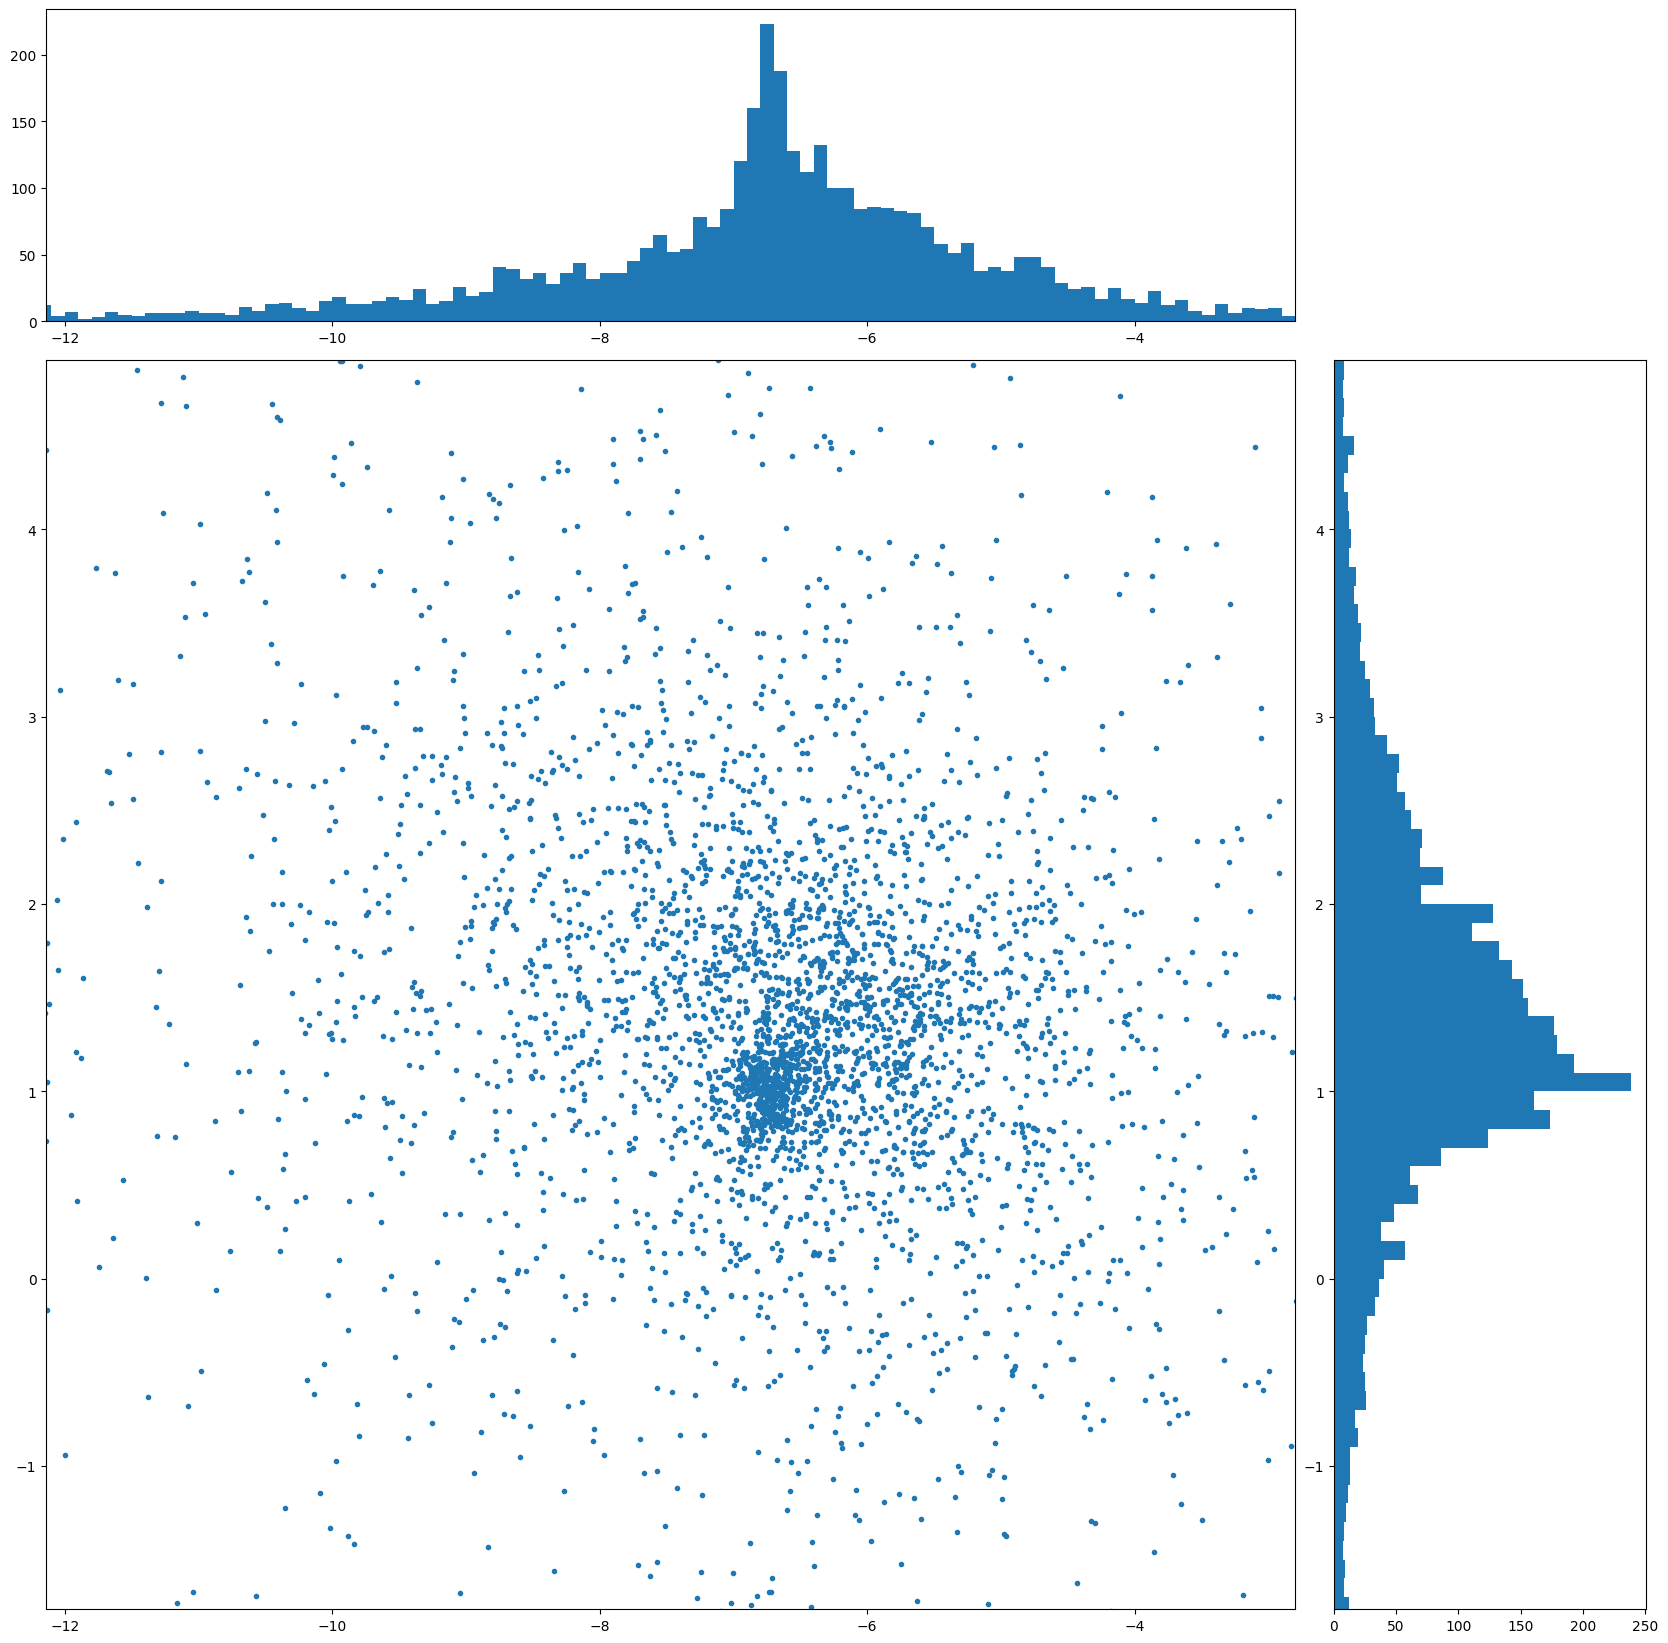

In [84]:
import matplotlib.pyplot as plt


def plot_pm_histogram(_data, rf=1):
    # Start with a square Figure.
    fig = plt.figure(figsize=(20, 20))
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # Draw the scatter plot and marginals.
    x = _data[:, 2]
    y = _data[:, 3]

    x_min = np.percentile(x, rf)
    x_max = np.percentile(x, 100 - rf)
    y_min = np.percentile(y, rf)
    y_max = np.percentile(y, 100 - rf)

    ax.scatter(x, y, marker='.')
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax / binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    plt.show()


plot_pm_histogram(astrometry, 3)

## Shuffle all data into subsets

In [85]:
# Shuffle
np.random.shuffle(astrometry)

# Split
astrometry_list = np.array_split(astrometry, obs_count)

## Label

In [92]:
import os


def get_label(_cluster, _data):
    pmra_min = _cluster["pm_ra_range"][0]
    pmra_max = _cluster["pm_ra_range"][1]
    pmdec_min = _cluster["pm_dec_range"][0]
    pmdec_max = _cluster["pm_dec_range"][1]
    a = (pmra_max - pmra_min) / 2
    b = (pmdec_max - pmdec_min) / 2
    center_pmra = (pmra_max + pmra_min) / 2
    center_pmdec = (pmdec_max + pmdec_min) / 2
    result = []
    for i in range(len(_data)):
        pm_ra = _data[i][2]
        pm_dec = _data[i][3]
        c = math.pow((pm_ra - center_pmra) / a, 2)
        label = 0
        if c < 1:
            dec_diff = b * math.sqrt(1 - c)
            if center_pmdec - dec_diff <= pm_dec <= center_pmdec + dec_diff:
                label = 1
        result.append(label)
    return np.array(result)


try:
    os.mkdir("data/{}".format(cluster_id))
except:
    pass

for i in range(obs_count):
    _obs = obs_list[i]
    _astrometry = astrometry_list[i]
    _label = get_label(_obs, _astrometry)
    np.save("data/{}/{}-feature.npy".format(cluster_id, i), _astrometry)
    np.save("data/{}/{}-label.npy".format(cluster_id, i), _label)

np.save("data/{}/raw.npy".format(cluster_id), import_astrometry(obs_list[0]["ra"], obs_list[0]["dec"], 3000))


    

ra: 174.08, dec: -61.63, radius: 0.07, #stars: 2863


In [87]:
pm_ranges = []
for i in range(obs_count):
    _obs = obs_list[i]
    print(_obs)
    pm_ranges.append([[_obs["pm_ra_range"][0], _obs["pm_ra_range"][1]], [_obs["pm_dec_range"][0], _obs["pm_dec_range"][1]]])

np.save("data/{}/obs.npy".format(cluster_id), pm_ranges)

{'cluster_id': 168, 'ra': 174.08, 'dec': -61.63, 'score': 0.186738, 'distance_range': (2.15, 2.43), 'pm_ra_range': (-6.91, -6.43), 'pm_dec_range': (0.78, 1.11)}
{'cluster_id': 168, 'ra': 174.07, 'dec': -61.63, 'score': 0.121337, 'distance_range': (1.57, 2.62), 'pm_ra_range': (-6.99, -6.52), 'pm_dec_range': (0.83, 1.09)}
{'cluster_id': 168, 'ra': 174.06, 'dec': -61.62, 'score': 0.0789776, 'distance_range': (1.94, 2.36), 'pm_ra_range': (-7.01, -6.56), 'pm_dec_range': (0.71, 1.3)}
{'cluster_id': 168, 'ra': 174.06, 'dec': -61.61, 'score': 0.0, 'distance_range': (1.5, 3.68), 'pm_ra_range': (-7.1, -5.93), 'pm_dec_range': (-0.09, 2.6)}
{'cluster_id': 168, 'ra': 174.09, 'dec': -61.62, 'score': 0.0, 'distance_range': (1.51, 2.99), 'pm_ra_range': (-7.7, -5.75), 'pm_dec_range': (0.07, 1)}
{'cluster_id': 168, 'ra': 174.06, 'dec': -61.61, 'score': 0.0, 'distance_range': (1.64, 2.03), 'pm_ra_range': (-9.28, -6.13), 'pm_dec_range': (0.36, 3.67)}
{'cluster_id': 168, 'ra': 174.08, 'dec': -61.62, 'score